In [68]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
import numpy as np
import random
import torch
import librosa
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import seaborn as sns
import pandas as pd
import sys
import cv2
from AEspeech import AEspeech
# from phonetGM2 import Phonet

In [69]:
from SpecDatset import SpecDataset
import time
import torch
import numpy as np
import pandas as pd
import numpy.fft
import os
import sys
from CAE import CAEn
PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

In [92]:
# create plot area or use the one provided
def show_scalogram(time, coefs=None, freqs=None, hop=50, spectrum='amp', ax=None, cscale='linear', cmap='jet', clim=None,
                  cbar='vertical', cbarlabel=None,cbarkw=None,figsize=(10, 4.0),yaxis='frequency', xlim=None, ylim=None, yscale='log', 
                  coi=False,ylabel="Frequency", xlabel="Time (s)", title=None):
    
    CBAR_DEFAULTS = {'vertical'   : { 'aspect':30, 'pad':0.03, 'fraction':0.05 },'horizontal' : { 'aspect':40, 'pad':0.12, 'fraction':0.05 }}

    COI_DEFAULTS = {'alpha':'0.5','hatch':'/'}
    snip_len=500
    FS=16000
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # adjust y axis ticks
    scales_period = np.divide(1,freqs)  # needed also for COI mask
    xmesh = np.concatenate([time, [time[-1]+hop]])
    if yaxis == 'period':
        ymesh = np.concatenate([scales_period, [scales_period[-1]]])
        ylim  = ymesh[[-1,0]] if ylim is None else ylim
        ax.set_ylabel("Period" if ylabel is None else ylabel)
    elif yaxis == 'frequency':
        df    = freqs[-1]/freqs[-2]
        ymesh = np.concatenate([freqs, [freqs[-1]*df]])
        # set a useful yscale default: the scale freqs appears evenly in logscale
        yscale = 'log' if yscale is None else yscale
        ylim   = ymesh[[-1, 0]] if ylim is None else ylim
        ax.set_ylabel("Frequency" if ylabel is None else ylabel)
        #ax.invert_yaxis()
    else:
        raise ValueError("yaxis must be one of 'frequency' or 'period', found "
                          + str(yaxis)+" instead")

    # limit of visual range
    xr = [time.min(), time.max()]
    if xlim is None:
        xlim = xr
    else:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    # adjust logarithmic scales on request (set automatically in Frequency mode)
    if yscale is not None:
        ax.set_yscale(yscale)

    # choose the correct spectrum display function and name
    if spectrum == 'amp':
        values = np.abs(coefs)
        sp_title = "Amplitude"
        cbarlabel= "abs(CWT)" if cbarlabel is None else cbarlabel
    elif spectrum == 'real':
        values = np.real(coefs)
        sp_title = "Real"
        cbarlabel= "real(CWT)" if cbarlabel is None else cbarlabel
    elif spectrum == 'imag':
        values = np.imag(coefs)
        sp_title = "Imaginary"
        cbarlabel= "imaginary(CWT)" if cbarlabel is None else cbarlabel
    elif spectrum == 'power':
        sp_title = "Power"
        cbarlabel= "abs(CWT)$^2$" if cbarlabel is None else cbarlabel
        values = np.power(np.abs(coefs),2)
    elif hasattr(spectrum, '__call__'):
        sp_title = "Custom"
        values = spectrum(coefs)
    else:
        raise ValueError("The spectrum parameter must be one of 'amp', 'real', 'imag',"+
                         "'power' or a lambda() expression")

    # labels and titles
    ax.set_title("Continuous Wavelet Transform "+sp_title+" Spectrum"
                 if title is None else title)
    ax.set_xlabel("Time/spatial domain" if xlabel is None else xlabel )
    if max(time)/FS>1:
        ax.set_xticklabels(map(str, np.linspace(0,max(time)/FS,6, dtype=np.int)))
    else:
        ax.set_xticks(np.linspace(0,(max(time)),6))
#         if coefs.shape[1]==256:
        ax.set_xticklabels(map(str, np.linspace(0,snip_len,6, dtype=np.int)))
#         else:
#             ax.set_xticklabels(map(str, np.linspace(0,(max(time)/FS)*1000,6, dtype=np.int)))
        ax.set_xlabel('Time (ms)')

    ax.set_yticklabels(map(str, np.linspace(0,np.log(8000),5, dtype=np.int)))
        
    if cscale == 'log':
        isvalid = (values > 0)
        cnorm = LogNorm(values[isvalid].min(), values[isvalid].max())
    elif cscale == 'linear':
        cnorm = None
    else:
        raise ValueError("Color bar cscale should be 'linear' or 'log', got:"+
                         str(cscale))

    # plot the 2D spectrum using a pcolormesh to specify the correct Y axis
    # location at each scale
    qmesh = ax.pcolormesh(xmesh, ymesh, values, cmap=cmap, norm=cnorm)

    if clim:
        qmesh.set_clim(*clim)

    # fill visually the Cone Of Influence
    # (locations subject to invalid coefficients near the borders of data)
    if coi:
        # convert the wavelet scales frequency into time domain periodicity
        scales_coi = scales_period
        max_coi  = scales_coi[-1]

        # produce the line and the curve delimiting the COI masked area
        mid = int(len(xmesh)/2)
        time0 = np.abs(xmesh[0:mid+1]-xmesh[0])
        ymask = np.zeros(len(xmesh), dtype=np.float16)
        ymhalf= ymask[0:mid+1]  # compute the left part of the mask
        ws    = np.argsort(scales_period) # ensure np.interp() works
        minscale, maxscale = sorted(ax.get_ylim())
        if yaxis == 'period':
            ymhalf[:] = np.interp(time0,
                  scales_period[ws], scales_coi[ws])
            yborder = np.zeros(len(xmesh)) + maxscale
            ymhalf[time0 > max_coi]   = maxscale
        elif yaxis == 'frequency':
            ymhalf[:] = np.interp(time0,
                  scales_period[ws], 1./scales_coi[ws])
            yborder = np.zeros(len(xmesh)) + minscale
            ymhalf[time0 > max_coi]   = minscale
        elif yaxis == 'scale':
            ymhalf[:] = np.interp(time0, scales_coi, scales)
            yborder = np.zeros(len(xmesh)) + maxscale
            ymhalf[time0 > max_coi]   = maxscale
        else:
            raise ValueError("yaxis="+str(yaxis))

        # complete the right part of the mask by symmetry
        ymask[-mid:] = ymhalf[0:mid][::-1]

        # plot the mask and forward user parameters
#         plt.plot(xmesh, ymask)
#         coikw = COI_DEFAULTS if coikw is None else coikw
#         ax.fill_between(xmesh, yborder, ymask, **coikw )

    # color bar stuff
    if cbar:
        cbarkw   = CBAR_DEFAULTS[cbar] if cbarkw is None else cbarkw
        colorbar = plt.colorbar(qmesh, orientation=cbar, ax=ax, **cbarkw)
        if cbarlabel:
            colorbar.set_label(cbarlabel)

    return ax


In [93]:
def create_wavelets(num_samples,nbf=8,dil=2):
    """
    Compute wavelet basis function for 'morl' wavelets
    ADAPTED from Phase retrieval for wavelet transforms: 
    http://www-math.mit.edu/~waldspur//wavelets_phase_retrieval.html#source_code

    :param num_samples: number of samples (should be equivalent to signal that will be transformed)
    :param dil: dilation factor between wavelets.
    :returns freqs: frequencies related to wavelets.
    :returns psi: 3D family of wavelets array with each wavelet being a row.
    :returns phi: gaussian low freq. function.
    """

    old_settings = np.seterr(under='ignore', over='ignore')

#     nbf=int(np.ceil(np.log(dil*num_samples/2)/np.log(dil)))
    freqs=[(num_samples/2)*np.power(1/dil,bf) for bf in np.arange(nbf)]

    ms=np.tile(freqs,(num_samples,1)).T
    oms=np.tile(np.arange(num_samples),(nbf,1))

    p=.3/(np.log(dil)/np.log(2))**2
    c=np.exp(-p) 

    d=1
    for k in range(10):
        d=1/(1-np.exp(-p*2*d))
       
    exp1=-p*(np.divide(d*oms,(ms-1))**2)
    exp2=-p*(np.divide(d*oms,ms)**2)

    psi=np.exp(exp1)-c*np.exp(exp2)

    max_psi=np.max(abs(psi))
    psi=np.float32(np.divide(psi,max_psi))
    phi=np.exp(-np.arange(num_samples)**2)

    return freqs,psi,phi

In [94]:
def wavelet_transform(signal,psi,phi=None,dil=2):
    """
    Compute wavelet transform of a signal
    ADAPTED from Phase retrieval for wavelet transforms: 
    http://www-math.mit.edu/~waldspur//wavelets_phase_retrieval.html#source_code
    
    :param signal: signal to be transformed
    :param psi: family of wavelets with each wavelet being a row.
    :param phi: gaussian low freq. function.
    :returns fpsi: components of the wavelet transform (time domain rep.).
    :returns fphi: conv. of signal with low-freq. filter
    """
    fphi=phi
    
    
#     if len(signal)<psi.shape[1]:
#         psi=create_wavelets(len(signal),psi.shape[0],dil)
        
#     signal=signal.T
    
    if len(signal) != np.shape(psi)[1]:
        print('The sizes of the wavelets and the signal do not match!')
        
    ft_sig=np.fft.fft(signal.T)
    fpsi=np.fft.ifft(np.multiply(psi,ft_sig))
    fphi=np.fft.ifft(np.multiply(phi,ft_sig))
    
    return fpsi,fphi
    

    

In [95]:
"""WAVELET TRANSFORM ON 500 mS SNIPPET OF SPEECH SIGNAL"""

'WAVELET TRANSFORM ON 500 mS SNIPPET OF SPEECH SIGNAL'

In [96]:
PATH=os.getcwd()
path_audio=PATH+'/tedx_spanish_corpus/speech/train/'
wav_file=path_audio+os.listdir(path_audio)[4]

fs,signal=read(wav_file)
if fs!=16000:
    raise ValueError(str(fs)+" is not a valid sampling frequency")

SNIP_LEN=500#in mS
NFR=int(signal.shape[0]*1000/(fs*SNIP_LEN))
FRAME_SIZE=int(signal.shape[0]/NFR)
OVRLP=0.5
SHIFT=int(FRAME_SIZE*OVRLP)
NBF=64

signal=signal-np.mean(signal)
signal=signal/np.max(np.abs(signal))

init=0
endi=FRAME_SIZE

frames=np.zeros((NFR,FRAME_SIZE))
fpsis=np.zeros((NFR,NBF,FRAME_SIZE))

for k in range(NFR):    
    frames[k,:]=signal[init:endi]                         
    init=init+int(SHIFT)
    endi=endi+int(SHIFT)
    cwtmatr, freqs = pywt.cwt(frames[k,:], np.arange(1,NBF+1), 'morl')
    fpsis[k,:,:]=cwtmatr

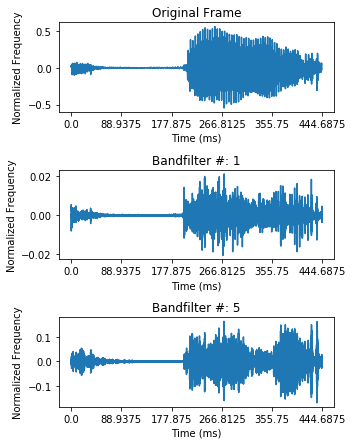

In [97]:
fig = plt.figure()

fr=11
fig.set_size_inches(5,12)
plt.subplot(6, 1, 1)
plt.plot(frames[fr,:])
plt.title("Original Frame")
# plt.yticks(np.linspace(-1,1,4))
plt.xticks(np.linspace(0,FRAME_SIZE,6), (np.arange(0,FRAME_SIZE,FRAME_SIZE//6)/fs)*1000)
plt.ylabel("Normalized Frequency")
plt.xlabel("Time (ms)")

for itr,ii in enumerate([1,5]):
    plt.subplot(6, 1, itr+2)
    plt.plot(fpsis[fr,ii,:])
    plt.title("Bandfilter #: "+str(ii))
    fig.tight_layout()
    plt.title("Bandfilter #: "+str(ii))
#     plt.yticks(np.linspace(-1,1,11))
    plt.xticks(np.linspace(0,FRAME_SIZE,6), (np.arange(0,FRAME_SIZE,FRAME_SIZE//6)/fs)*1000)
    
    plt.ylabel("Normalized Frequency")

    plt.xlabel("Time (ms)")
    fig.tight_layout()


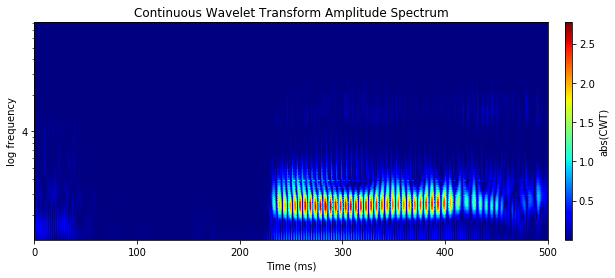

In [98]:
ax=show_scalogram(np.arange(FRAME_SIZE),fpsis[11,:,:],freqs,2, yaxis='frequency', ylabel='log frequency')

In [99]:
width = 512
height = NBF
dim = (width, height)

bicubic_img = cv2.resize(fpsis[fr,:,:],dim, interpolation = cv2.INTER_CUBIC)
# bicu=np.load("./tedx_spanish_corpus/reps/wvlt/train/TEDX_F_001_SPA_0001_4.npy")
bicubic_img.shape

(64, 512)

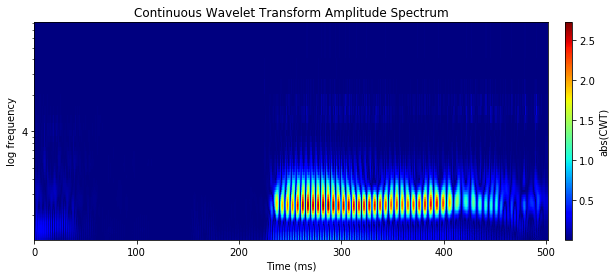

In [100]:
show_scalogram(np.arange(width),bicubic_img, freqs, hop=2, yaxis='frequency', ylabel='log frequency')

In [ ]:
#Below we look at transform for entire speech signal

In [ ]:
PATH=os.getcwd()
path_audio=PATH+'/tedx_spanish_corpus/speech/train/'
wav_file=path_audio+os.listdir(path_audio)[1]

fs,signal=read(wav_file)
fs_new=16000

if fs!=16000:
    raise ValueError(str(fs)+" is not a valid sampling frequency")

NFR=200
FRAME_SIZE=int(signal.shape[0]/NFR)
OVRLP=0.5
TIME_SHIFT=int(FRAME_SIZE*OVRLP)
NBF=64

signal=signal-np.mean(signal)
signal=signal/np.max(np.abs(signal))


# scales = np.arange(1,len(signal), 3200)*pywt.central_frequency('morl')    

# cwt= scg.CWT(np.arange(len(signal)),signal,scales)
# cmp_coefs=cwt.coefs
# freqs=cwt.scales_freq
# np.shape(cmp_coefs)


fpsi, freqs = pywt.cwt(signal, np.arange(1,NBF+1), 'morl')
# fpsi,fphi=wavelet_transform(signal,psi,phi)
# fpw=np.mean(fpsi**2,axis=1)
# wv_mat=fpw

In [ ]:
fpsi.shape

In [ ]:
fig = plt.figure()

fr=10
fig.set_size_inches(5,12)
plt.subplot(6, 1, 1)
plt.plot(signal)
plt.title("Original Signal")
plt.yticks(np.linspace(-1,1,4))
plt.xticks(np.linspace(0,len(signal),6), np.arange(0,len(signal)//fs_new))
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")

for itr,ii in enumerate([4,25,50,63]):
    plt.subplot(6, 1, itr+2)
    plt.plot(fpsi[ii,:])
    plt.title("Bandfilter #: "+str(ii))
#     plt.yticks(np.linspace(-1,1,11))
    plt.xticks(np.linspace(0,len(signal),6), np.arange(0,len(signal)//fs_new))
    plt.ylabel("Normalized Frequency")
    plt.xlabel("Time (s)")
    fig.tight_layout()

In [ ]:
width = 256
height = 64
dim = (width, height)

bicubic_img = cv2.resize(fpsi,dim, interpolation = cv2.INTER_CUBIC)
# bicu=np.load("./tedx_spanish_corpus/reps/wvlt/train/TEDX_F_001_SPA_0001_4.npy")
bicubic_img.shape

In [ ]:
ax=show_scalogram(np.arange(256),bicubic_img,freqs,2, yaxis='frequency', ylabel='frequency')

In [ ]:
PATH=os.getcwd()
path_audio=PATH+'/tedx_spanish_corpus/speech/train/'
wav_file=path_audio+os.listdir(path_audio)[2]

fs,signal=read(wav_file)
fs_new=16000

if fs!=16000:
    raise ValueError(str(fs)+" is not a valid sampling frequency")

FS=16000
FRAME_SIZE=0.5
TIME_SHIFT=0.25
DIL=1.1
NBF=16
NFR=16
OVRLP=0.75
FRM_SZ=int(FRAME_SIZE*FS/NFR)
TS=int(FRM_SZ*OVRLP)

signal=signal-np.mean(signal)
signal=signal/np.max(np.abs(signal))

init=0
endi=int(FS*FRAME_SIZE)

nf=int(len(signal)/(TIME_SHIFT*FS))-1
[freqs,psi,phi]=create_wavelets(FRM_SZ,nbf=NBF,dil=DIL)

wv_mat=np.zeros((nf,NFR,NBF),dtype=np.float32)
fpsis=np.zeros((nf,NFR,NBF,FRM_SZ))

if nf>0:
    for k in range(nf):
#         try:
        frame=signal[init:endi]
        init=init+int(TIME_SHIFT*FS)
        endi=endi+int(TIME_SHIFT*FS)
        
        inin=0
        enin=FRM_SZ
        
        for kk in range(NFR):
            
            framein=frame[inin:enin]                       
            inin=inin+int(TS)
            enin=enin+int(TS)
            if len(framein)<FRM_SZ:
                framein=np.pad(framein,FRM_SZ-len(framein))
                framein=framein[:FRM_SZ]

            fpsis[k,kk,:,:],fphi=wavelet_transform(framein,psi,phi)
            fpw=(np.mean(fpsis[k,kk,:,:]**2,axis=1))
            wv_mat[k,kk,:]=fpw
        
        

In [ ]:
fig,a=plt.subplots()

fig.set_size_inches(20,2)
a.set_yticks(np.linspace(NBF,0,4))
a.set_yticklabels(map(str, np.linspace(0,NBF,4, dtype=np.int)))
a.set_xticks(np.linspace(0,FRM_SZ,6))
a.set_xticklabels(map(str, np.linspace(0,(FRM_SZ/FS)*1000,6, dtype=np.int)))
a.set_ylabel("bandfilter")
a.set_xlabel("time (ms)")
# plt.tight_layout()

a.imshow(np.flipud((fpsis[22,5,:,:])), cmap=plt.cm.viridis)
plt.show()